In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC

In [2]:
pd.set_option('display.expand_frame_repr', False)
spoty_df = pd.read_csv('SpotifyFeatures.csv')

spoty_df = shuffle(spoty_df)

### Dataset structure

In [3]:
print(spoty_df.head())
print(spoty_df.describe())
print(spoty_df.info())
print(spoty_df['genre'])

             genre   artist_name            track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
216921       World       Passion  You Revive Me - Live  4AN1qIXVBmlnxJ1sVmpP6y          34        0.2540         0.279       435893   0.439          0.000010   D     0.949    -6.587  Major       0.0330  140.161            4/4   0.0853
94924        Indie   St. Vincent              New York  5IXTT9RvcVupmzLTFqIInj          60        0.8920         0.373       154960   0.449          0.000013  A#     0.175   -11.646  Major       0.1440  137.866            4/4   0.3270
177410        Jazz        B-Side             Don't Cry  7clHGm0ViGbC884Yrr5gNL          41        0.0237         0.725       230250   0.267          0.922000  A#     0.281   -11.299  Major       0.1810  146.148            4/4   0.4000
198090  Soundtrack  Howard Shore   The Ring Goes South  6IQY

### management of null, infinite and duplicate values

In [4]:
#checking null values
null_values = spoty_df.isnull()
null_columns = null_values.any()
print("Colonne con valori nulli:")
print(null_columns)

Colonne con valori nulli:
genre               False
artist_name         False
track_name           True
track_id            False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
dtype: bool


In [5]:
#checking infinite values
if spoty_df.select_dtypes(include=[np.number]).applymap(np.isinf).any().any():
    print("Sono presenti valori infiniti nel DataFrame.")
else:
    print("Non sono presenti valori infiniti nel DataFrame.")

C:\Users\rugge\AppData\Local\Temp\ipykernel_29196\2903672945.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if spoty_df.select_dtypes(include=[np.number]).applymap(np.isinf).any().any():


Non sono presenti valori infiniti nel DataFrame.


In [6]:
#checking and removing duplicates
duplicates = spoty_df[spoty_df.duplicated(subset=['track_id'])]
print("duplicates:")
print(duplicates)
spoty_df = spoty_df.drop_duplicates(subset=['track_id'])
genre_counts = spoty_df['genre'].value_counts()
print(genre_counts)

duplicates:
                   genre            artist_name                   track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
121539               Rap                   Russ              No Turning Back  3ifyEy9pIoaY1DbJ7o3LX0          52      0.056300         0.681       154827   0.674          0.000000   F    0.1410    -4.615  Minor       0.4220  185.819            4/4    0.520
40973               Folk            Billy Bragg             California Stars  38paDDziQ57k1f4VfKTeGk          63      0.422000         0.622       298533   0.736          0.000012   A    0.0829    -9.229  Major       0.0292  110.240            4/4    0.723
37020         Electronic                   Bent              Chocolate Wings  4AWVzEy8iOj0lXfIk0VhcP          39      0.034000         0.649       351413   0.818          0.401000   C    0.1470    -7.498  Major       

### Selection of genres and elimination of uninteresting features

In [7]:
#Selection of the genres of interest.
desired_genres = ['Rock', 'Classical', 'Jazz']
top3_df = spoty_df[spoty_df['genre'].isin(desired_genres)]
genre_counts = top3_df['genre'].value_counts()
print(genre_counts)

genre
Classical    8624
Jazz         8230
Rock         4663
Name: count, dtype: int64


In [8]:
#Elimination of features that are certainly useless.
top3_df = top3_df.drop(['artist_name'], axis=1)
top3_df = top3_df.drop(['track_name'], axis=1)
top3_df = top3_df.drop(['track_id'], axis=1)
top3_df = top3_df.drop(['duration_ms'], axis=1)

# EDA

In [9]:
# Selection of only the numerical columns.
features = top3_df.select_dtypes(include=np.number).columns.tolist()

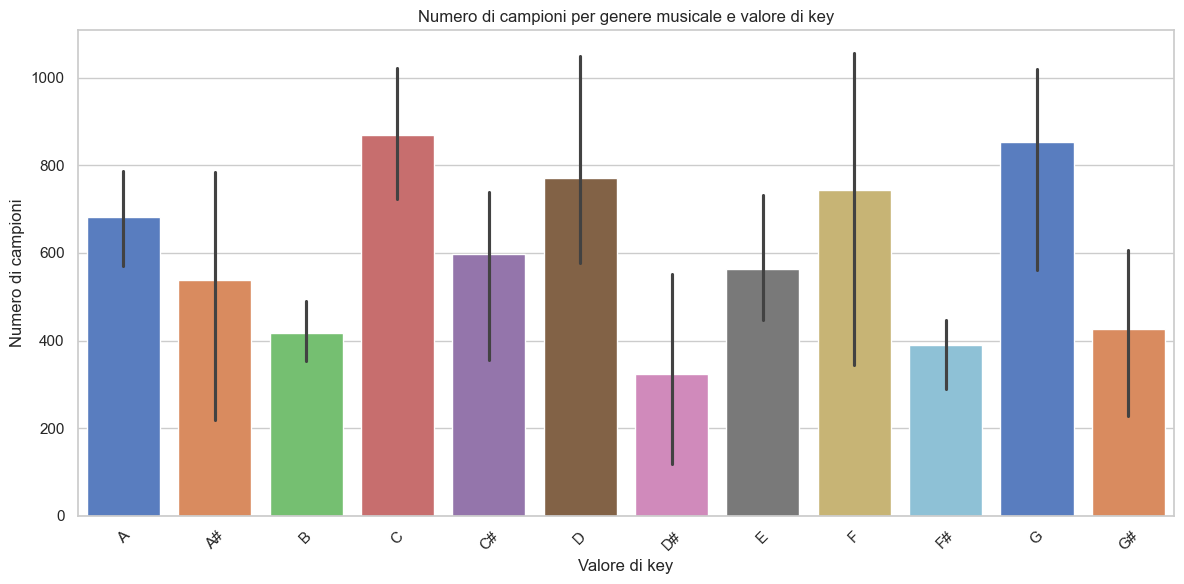

In [10]:
grouped = top3_df.groupby(['genre', 'key']).size().unstack(fill_value=0)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, palette="muted")
plt.xlabel('Valore di key')
plt.ylabel('Numero di campioni')
plt.title('Numero di campioni per genere musicale e valore di key')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Handling of time_signature

In [11]:
print(top3_df['time_signature'].unique())
#It is very likely that the entry of 1/4 is a data entry error because it is equivalent to 4/4.
top3_df.loc[:, 'time_signature'] = top3_df['time_signature'].replace(['1/4'], '4/4')
print("Tracks with a 0/4 time signature: %s" % len(top3_df[top3_df['time_signature'] == '0/4']))
top3_df = top3_df[top3_df['time_signature'] != '0/4']  # Remove the rows with '0/4' from the 'time_signature' column.

['4/4' '3/4' '1/4' '5/4']
Tracks with a 0/4 time signature: 0


### Genre distribution

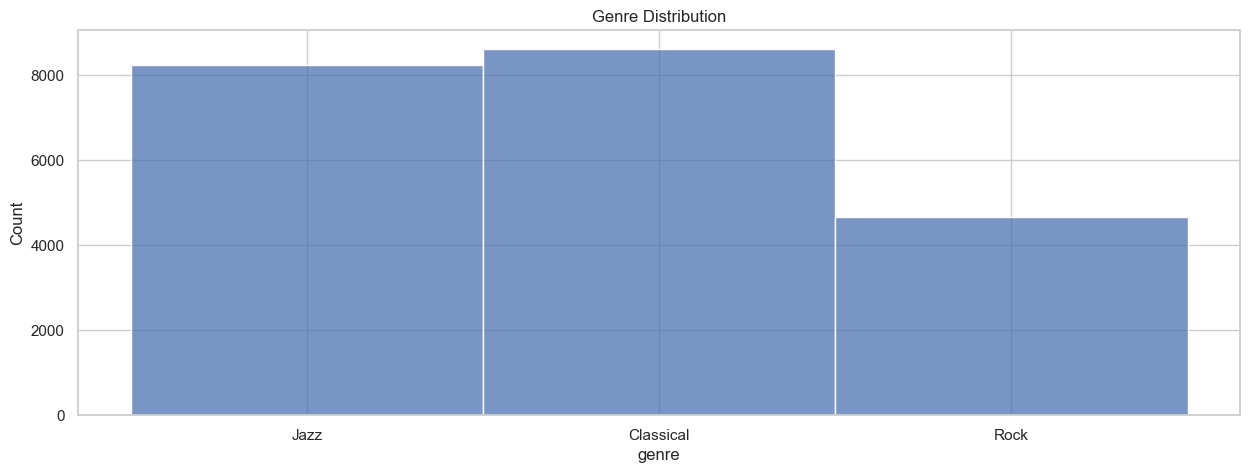

In [12]:
plt.figure(figsize=(15, 5))
sns.histplot(top3_df['genre']).set_title('Genre Distribution')
plt.show()

In [13]:
# We notice that the dataset is unbalanced.

## Conversion of categorical values

In [14]:
#We use labels because they are ordinal categorical values
time_signature_mapping = {'3/4': 0,'4/4':1 ,'5/4': 2}
top3_encoded_df=top3_df
top3_encoded_df['time_signature'] = top3_encoded_df['time_signature'].map(time_signature_mapping)
mode_mapping = {'Major': 1,'Minor':0}
top3_encoded_df['mode'] = top3_encoded_df['mode'].map(mode_mapping)
notes_ordered = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
key_mapping = {note: index for index, note in enumerate(notes_ordered)}
top3_encoded_df['key'] = top3_encoded_df['key'].map(key_mapping)
print(top3_df.head())

            genre  popularity  acousticness  danceability   energy  instrumentalness  key  liveness  loudness  mode  speechiness    tempo  time_signature  valence
177410       Jazz          41        0.0237         0.725  0.26700            0.9220   10    0.2810   -11.299     1       0.1810  146.148               1   0.4000
145480       Jazz          63        0.9630         0.515  0.02830            0.9270    9    0.0906   -28.954     1       0.0402  100.598               1   0.0886
146075       Jazz          55        0.9840         0.350  0.11400            0.0101    2    0.2850   -15.725     0       0.0332  113.382               1   0.2650
130820  Classical          25        0.9890         0.301  0.00602            0.0199    5    0.0917   -34.733     0       0.0414   83.628               1   0.2240
166923       Rock          66        0.0452         0.264  0.78000            0.0222    0    0.3760    -2.741     1       0.0517  155.376               1   0.4560


## Normalization

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

top3_encoded_df['loudness'] *= -1

# Splitting labels from features
t = top3_encoded_df['genre']
X = top3_encoded_df.drop(['genre'], axis=1)

# Splitting the dataset in train and test
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

#Merging X_train and X_test, t_train and t_test into a single DataFrame
X_combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

t_train = pd.DataFrame(t_train).reset_index(drop=True)
t_test = pd.DataFrame(t_test).reset_index(drop=True)

X_train['genre'] = t_train
X_test['genre'] = t_test

df_with_labels = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

#final dataframe
print("\ncombined_df_with_labels:")
print(df_with_labels)



combined_df_with_labels:
       popularity  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness     tempo  time_signature   valence      genre
0       -0.482634     -0.085741     -0.330736 -0.503744          1.008370 -1.484648 -0.368757  0.466846  0.763350     0.069488  1.054506        0.313019 -0.592732  Classical
1        0.015111      1.012747     -1.650723 -1.118886          1.055506  1.683428 -0.180231  1.087873  0.763350    -0.108805  2.002201       -2.182679 -1.235277  Classical
2       -2.473616      0.850294     -0.931200 -1.049059          0.023469 -0.908634 -0.422621  0.739030  0.763350    -0.467043 -0.441983        0.313019 -0.836176  Classical
3       -0.669288      1.033375     -1.474724 -1.219303         -0.978648  0.531401 -0.294693  1.989788  0.763350    -0.371293 -0.922709        0.313019 -1.321958  Classical
4       -0.109325     -1.496317      1.455129  0.965945         -0.981278  0.819408 -0.045570 -0.550475 

## Further data exploration

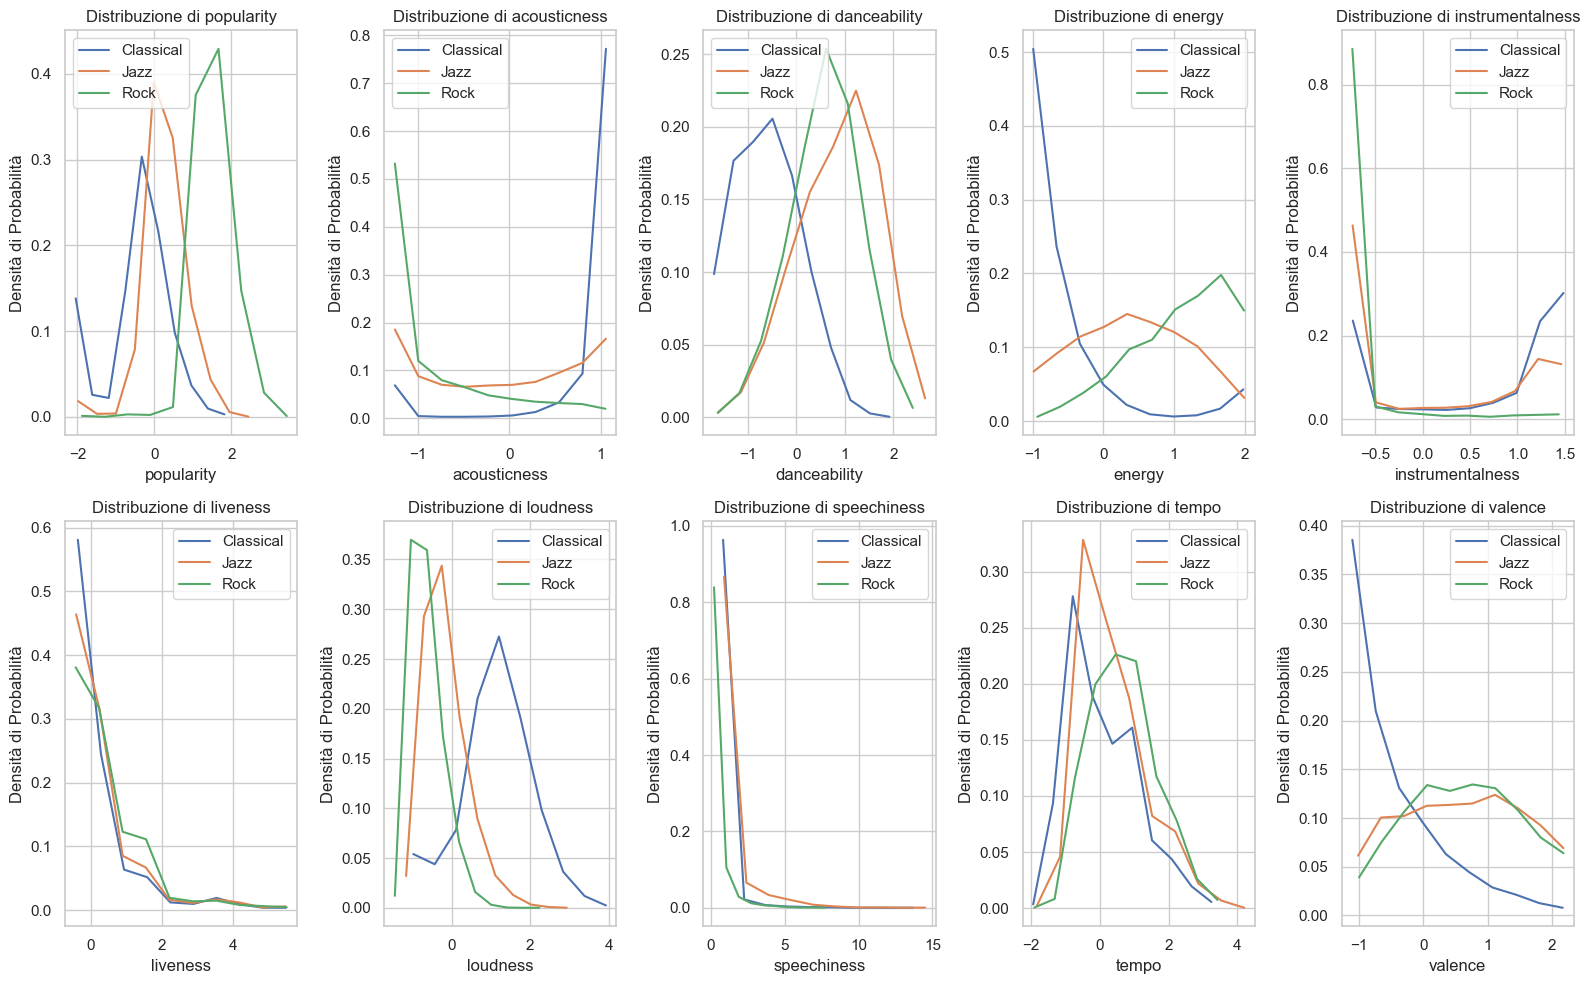

In [16]:
num_rows = 2
num_cols = (len(features) + 1) // 2
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, start=1):
    plt.subplot(num_rows, num_cols, i)

    for genre, data in df_with_labels.groupby('genre'):
        counts, bin_edges = np.histogram(data[feature], bins=10, density=True)
        pdf = counts / sum(counts)

        plt.plot(bin_edges[1:], pdf, label=genre)

    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densità di Probabilità')
    plt.legend()

plt.tight_layout()
plt.show()

In [17]:
#We might consider dropping tempo, speechiness, liveness, and instrumentalness since their distributions are largely
#overlapping and thus not sufficiently discriminating.

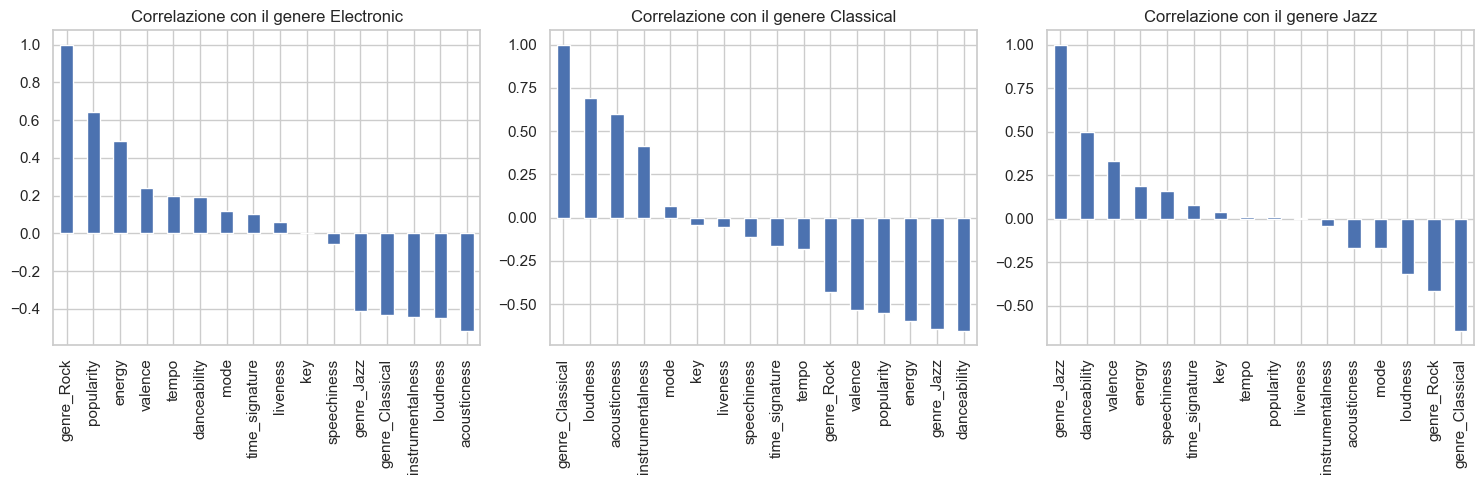

In [18]:
#Let's try to understand which features better explain the genres.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
X_dummies=pd.get_dummies(df_with_labels)
X_dummies.corr()['genre_Rock'].sort_values(ascending=False).plot(kind='bar', ax=axs[0])
axs[0].set_title('Correlazione con il genere Electronic')
X_dummies.corr()['genre_Classical'].sort_values(ascending=False).plot(kind='bar', ax=axs[1])
axs[1].set_title('Correlazione con il genere Classical')
X_dummies.corr()['genre_Jazz'].sort_values(ascending=False).plot(kind='bar', ax=axs[2])
axs[2].set_title('Correlazione con il genere Jazz')
plt.tight_layout()
plt.show()

In [19]:
#The result of the previous graph is confirmed by this graph. We also notice that key doesn't explain well enough the genre.

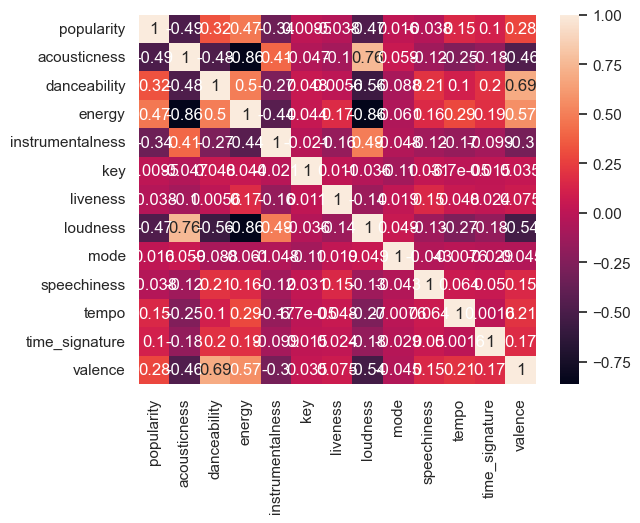

In [20]:
#Analysis of the correlation between features
corr_matrix = df_with_labels.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [21]:
#We notice that energy is highly correlated with acousticness, and we might consider dropping one of them.

In [22]:
df_with_labels=df_with_labels.reset_index(drop=True).drop(columns=['key','instrumentalness','speechiness','liveness','tempo','time_signature'], axis=1)


#top5_encoded_df.drop('energy', axis=1)


# Outlier management

C:\Users\rugge\AppData\Local\Temp\ipykernel_29196\21306688.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_with_labels.drop(['genre'], axis=1).columns, rotation=45)  # Imposta i nomi delle colonne come etichette sull'asse x


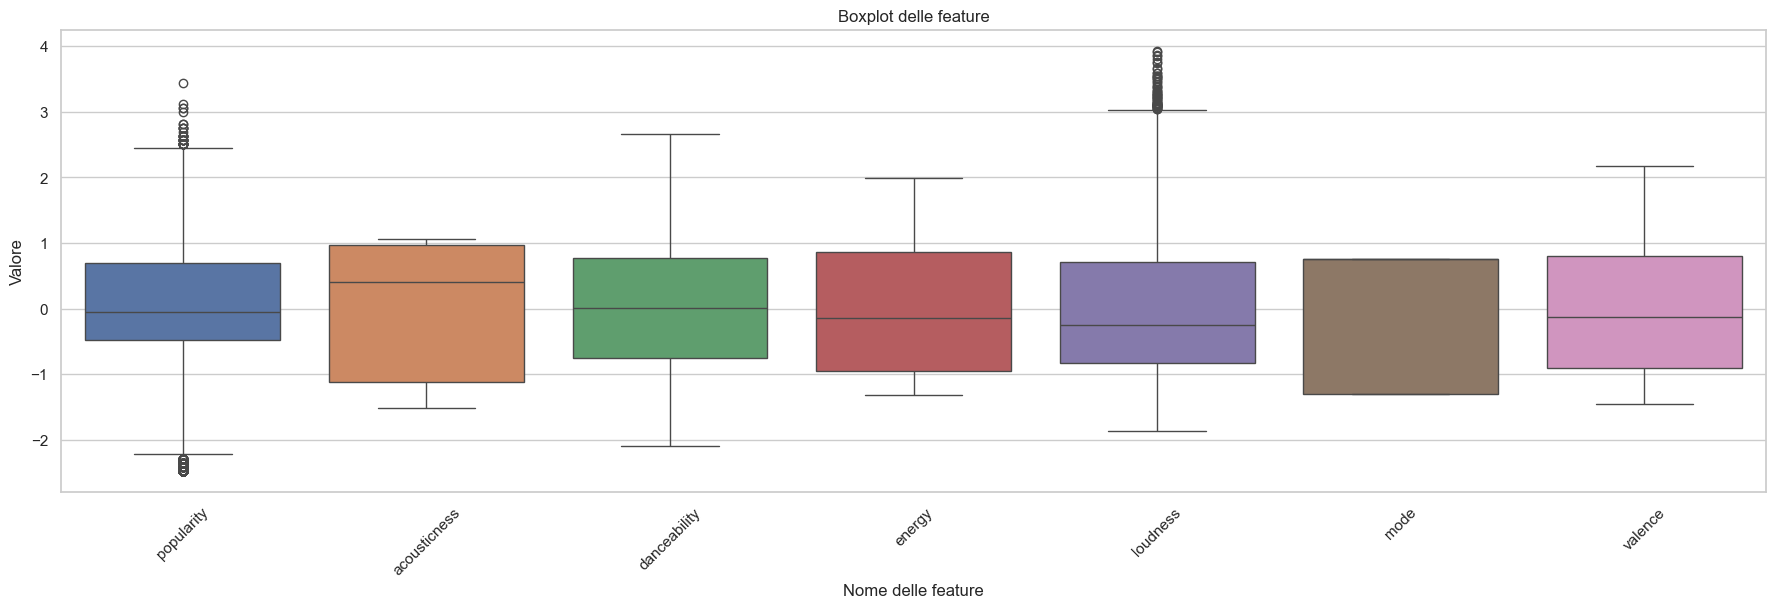

In [23]:
#grafico box per controllare outlier
plt.figure(figsize=(22, 6))
ax = sns.boxplot(data=df_with_labels.drop(['genre'], axis=1).values)
ax.set_xticklabels(df_with_labels.drop(['genre'], axis=1).columns, rotation=45)  # Imposta i nomi delle colonne come etichette sull'asse x
plt.xlabel('Nome delle feature')  # Aggiungi un'etichetta all'asse x
plt.ylabel('Valore')  # Aggiungi un'etichetta all'asse y
plt.title('Boxplot delle feature')  # Aggiungi un titolo al grafico
plt.show()

#print(X_train.head())
#mi concentro sulle feature 5,6,8 che sono quelle con outlier (tempo, liveness, loudaness e  speechiness)

In [24]:
#Splitting into train and test to remove outliers only from train
t = df_with_labels['genre']
X = df_with_labels.drop(['genre'], axis=1)

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

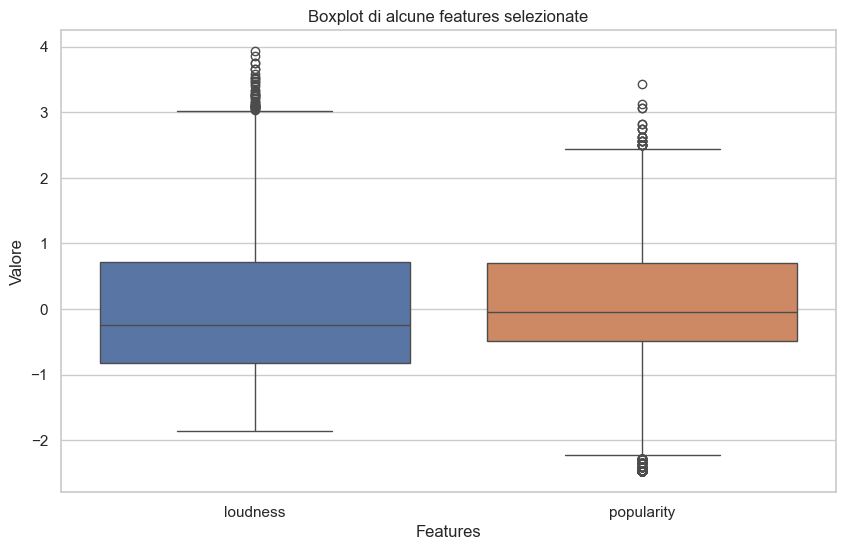

In [25]:
selected_columns = X_train[[ 'loudness','popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()

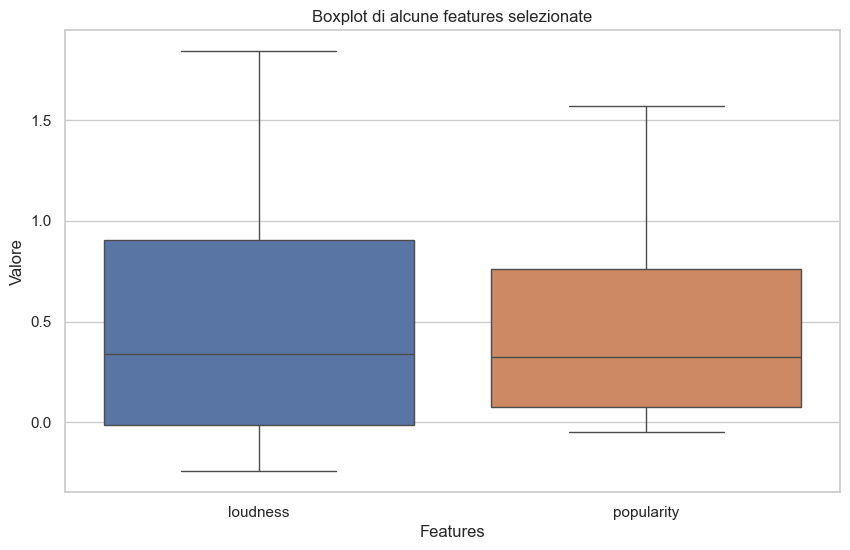

In [26]:
# Removing outliers from X_train and corresponding records from y_train
quantiles = X_train[['loudness','popularity']].quantile([0.5, 0.95])
lower_quantile = quantiles.iloc[0]
upper_quantile = quantiles.iloc[1]

X_train = X_train[(X_train['loudness'] >= lower_quantile['loudness']) & (X_train['loudness'] <= upper_quantile['loudness'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

X_train = X_train[(X_train['popularity'] >= lower_quantile['popularity']) & (X_train['popularity'] <= upper_quantile['popularity'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

# Graph without outliers
selected_columns = X_train[['loudness', 'popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()


## VIF

In [27]:
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)


        Feature   VIF
3        energy  7.38
4      loudness  3.70
1  acousticness  3.31
6       valence  2.37
2  danceability  2.07
0    popularity  1.49
5          mode  1.01


In [28]:
# we notice we could drop energy

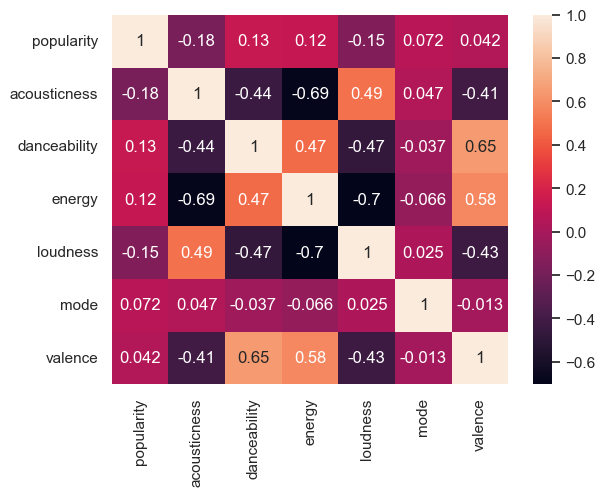

In [29]:
#Let's check if the correlation matrix gives us the same result
corr_matrix = X_train.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()
# we can definetly drop energy

In [30]:
X_train.drop('energy', axis=1, inplace=True)
X_test.drop('energy', axis=1, inplace=True)
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)

        Feature   VIF
3      loudness  2.27
1  acousticness  2.13
5       valence  2.10
2  danceability  2.01
0    popularity  1.27
4          mode  1.01


# logistic regression

In [31]:
hyper_param = [
    {
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs','newton-cg', 'sag', 'saga'],
        'max_iter': [100, 1000, 2500]
    }
]

# Model creation and training using grid search
clf = GridSearchCV(linear_model.LogisticRegression(multi_class='multinomial'), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_weighted')
best_clf = clf.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clf.best_params_)
print("F1 score on the train set: ", clf.best_score_)

# Training the best model on the complete training data
best_model = linear_model.LogisticRegression(**clf.best_params_)
best_model.fit(X_train, t_train)

# Prediction on the test set
t_hat_test = best_model.predict(X_test)

# Calculation of evaluation metrics on the test set
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))
print(classification_report(t_test, t_hat_test))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Tuned hyperparameters (best parameters):  {'C': np.float64(0.23357214690901212), 'max_iter': 100, 'solver': 'lbfgs'}
F1 score on the train set:  0.8023335669407009
Accuracy score on the test set:  0.8460346964064436
F1 score on the test set:  0.8469611041201957
              precision    recall  f1-score   support

   Classical       0.94      0.78      0.85      2603
        Jazz       0.76      0.89      0.82      2455
        Rock       0.87      0.89      0.88      1398

    accuracy                           0.85      6456
   macro avg       0.86      0.85      0.85      6456
weighted avg       0.86      0.85      0.85      6456



c:\Users\rugge\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Confusion matrix

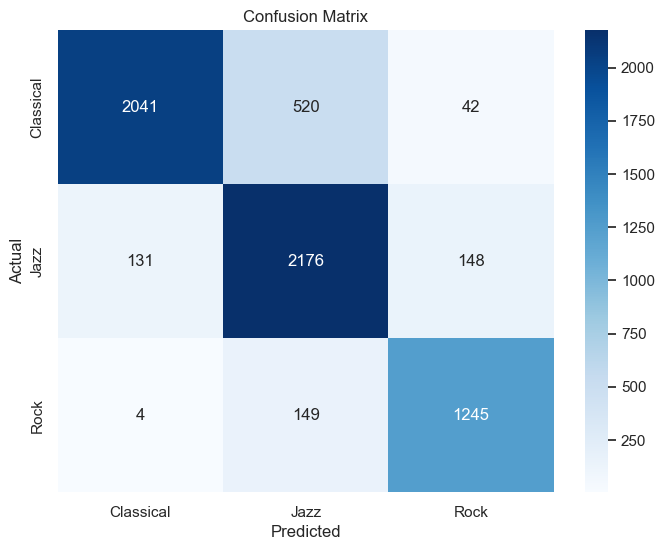

In [32]:
conf_matrix = confusion_matrix(t_test, t_hat_test)

labels = ['Classical', 'Jazz','Rock']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [33]:
hyper_param = [
    {
        'n_neighbors': [3, 7,9,11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
]

clfKNN = GridSearchCV(KNeighborsClassifier(), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise",scoring='f1_macro')
best_clf = clfKNN.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clfKNN.best_params_)
print("Accuracy:", clfKNN.best_score_)

t_hat_test = clfKNN.predict(X_test)
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))


# Training the best model on the complete training data
model = KNeighborsClassifier(**clfKNN.best_params_)
model.fit(X_train, t_train)

# Prediction on the test set
t_pred = model.predict(X_test)

# Calculation of evaluation metrics on the test set
print(classification_report(t_test, t_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tuned hyperparameters (best parameters):  {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.7452638544809971
Accuracy score on the test set:  0.8104089219330854
F1 score on the test set:  0.812069542415188
              precision    recall  f1-score   support

   Classical       0.93      0.73      0.82      2603
        Jazz       0.71      0.89      0.79      2455
        Rock       0.86      0.81      0.84      1398

    accuracy                           0.81      6456
   macro avg       0.83      0.81      0.82      6456
weighted avg       0.83      0.81      0.81      6456



## ROC-AUC

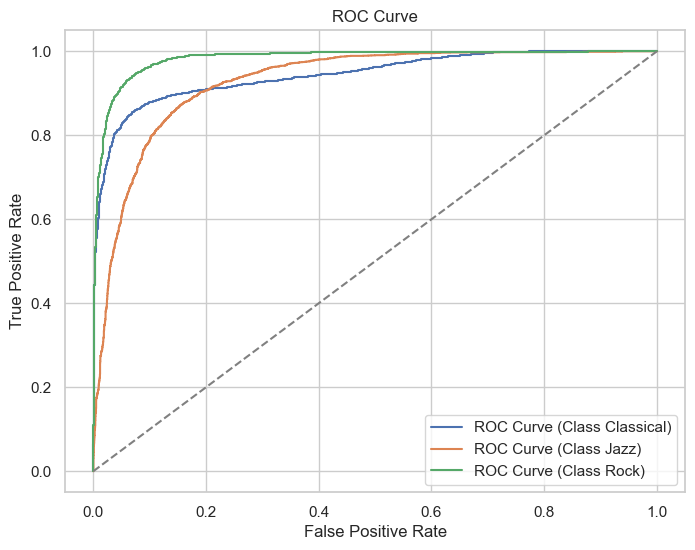

In [34]:
# Calculate the class probabilities for the test set
probs = clf.predict_proba(X_test)

# Calculate the ROC-AUC for each class
roc_auc = roc_auc_score(t_test, probs, multi_class='ovr')  # 'ovr' for multiclass problems

#Calculate and plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(t_test == labels[i], probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC Curve (Class {labels[i]})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network

In [35]:
print(t_train)

16177         Rock
19476         Jazz
8030          Jazz
2284          Jazz
73       Classical
           ...    
16354         Jazz
889      Classical
6901          Rock
5769          Jazz
17186         Jazz
Name: genre, Length: 2150, dtype: object


In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
t_train = encoder.fit_transform(t_train)  # Converti le stringhe in numeri
t_test = encoder.transform(t_test) 

hyper_param_mlp = {
    'hidden_layer_sizes': [(100,100), (100, 150), (150, 150)],
    'activation': [ 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True, False],
    'max_iter': [500]
}

clfMLP = GridSearchCV(MLPClassifier(), param_grid=hyper_param_mlp, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_mlp = clfMLP.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clfMLP.best_params_)
print("Accuracy:", clfMLP.best_score_)

best_mlp_model = MLPClassifier(**clfMLP.best_params_)
best_mlp_model.fit(X_train, t_train)

t_hat_test_mlp = best_mlp_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_hat_test_mlp, average='weighted'))

print(classification_report(t_test, t_hat_test_mlp))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuned hyperparameters (best parameters):  {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (150, 150), 'max_iter': 500, 'solver': 'adam'}
Accuracy: 0.7825984897350835
F1 score on the test set:  0.7943228048425912
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2603
           1       0.68      0.90      0.77      2455
           2       0.89      0.89      0.89      1398

    accuracy                           0.80      6456
   macro avg       0.84      0.81      0.81      6456
weighted avg       0.83      0.80      0.79      6456



# SVM

In [37]:
hyper_param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

clf_svm = GridSearchCV(SVC(), param_grid=hyper_param_svm, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_svm = clf_svm.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clf_svm.best_params_)
print("Accuracy:", clf_svm.best_score_)

best_svm_model = SVC(**clf_svm.best_params_)
best_svm_model.fit(X_train, t_train)

t_pred_svm = best_svm_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_pred_svm, average='weighted'))
print(classification_report(t_test, t_pred_svm))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned hyperparameters (best parameters):  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7775399020376641
F1 score on the test set:  0.8510800027207864
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2603
           1       0.79      0.86      0.82      2455
           2       0.84      0.91      0.87      1398

    accuracy                           0.85      6456
   macro avg       0.85      0.86      0.85      6456
weighted avg       0.86      0.85      0.85      6456

